<a href="https://colab.research.google.com/github/IrisFDTD/AI-UNIZAR-course/blob/main/recurrent_networks/ai_unizar_course_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">*Introducción a la inteligencia artificial: redes neuronales avanzadas con Tensorflow-Keras*</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Sergio Gutiérrez Rodrigo (sergut@unizar.es)</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Licencia Creative Commons Atribución-NoComercial-CompartirIgual 4.0 Internacional</a>.

```
Sergio G Rodrigo
Departamento de Física Aplicada
Universidad de Zaragoza
Instituto de Nanociencia y Materiales de Aragón (INMA)
C/ Pedro Cerbuna, 12, 50009, Zaragoza, España
```






# **Advanced Neural Networks with TensorFlow-Keras**

---
# **Time Series Prediction with Recurrent Neural Networks (RNN)**
---


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Auxiliary functions

In [17]:
def plot_history(history):
    train_loss = history.history['loss']
    epochs = range(1, len(train_loss) + 1)

    # Extract the validation loss values
    val_loss = history.history['val_loss']

    # Plot the training loss and validation loss vs. epoch
    plt.rcParams.update({'font.size': 14})
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    pass


def plot_time_series(x,y_true,model,model_name):
    # Create the plot
    j=np.random.randint(x.shape[0])

    n_steps=x.shape[1]
    print(n_steps)
    time=list(range(1, n_steps + 1))

    pred=model.predict(x[j].reshape(1, n_steps, 1))
    print(pred.shape)
    final_step=pred.shape[1]
    series=x[j]
    true=y_true[j][0:final_step]

    pred=np.squeeze(pred)
    true=np.squeeze(true)

    time_pred=np.arange(n_steps + 1,n_steps + 1+final_step)

    print("MSE=",tf.keras.metrics.mse([true],[pred]).numpy())

    plt.rcParams.update({'font.size': 14})
    plt.plot(time,series,label='data',marker='o',markersize=5)
    plt.plot(time_pred,true,'ro',label='target')
    plt.plot(time_pred,pred,'x',color='black',label=model_name)
    plt.xlabel(r'$t$ (time in a.u.)')
    plt.ylabel(r'$s(t)$')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
    # Show the plot
    plt.show()
    pass

# Generating time series: toy model

$s(t)$ signal as a function of time = two sinusoidal waves + noise
---

$s(t)=\dfrac{1}{2}\sin[(t-\phi_1)(10\omega_1+10)]+\dfrac{1}{5}\sin[(t-\phi_2)(20\omega_2+20)]+noise$

where:
+ $\omega_1, \omega_2, \phi_1, \phi_2 \in [0,1]$
+ $\Delta t=\dfrac{1}{n_{steps}}=\frac{1}{60}$
+ $noise \in [-0.05,0.05]$

In [3]:
def generate_time_series(batch_size, n_steps):
  '''
  Return 4 vectors of random numbers of length batch_size
  '''
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
  return series[..., np.newaxis].astype(np.float32) # data shape for RNN (batch_size,time steps,number of features)

In [4]:
# Generate time series: n_steps for training and n_target as targets
n_steps = 50
n_target = 10
N_series=1000
N_train=700
N_val=200
N_test=100

series = generate_time_series(N_series, n_steps + n_target)
print("Time series shape (batch_size,time steps,number of features)=",series.shape)

X_train, Y_train = series[:N_train, :n_steps], series[:N_train, -n_target:, 0]
X_val, Y_val = series[N_train:N_train+N_val, :n_steps], series[N_train:N_train+N_val, -n_target:, 0]
X_test, Y_test = series[N_series-N_test:, :n_steps], series[N_series-N_test:, -n_target:, 0]

Time series shape (batch_size,time steps,number of features)= (1000, 60, 1)


In [5]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(700, 50, 1) (700, 10)
(200, 50, 1) (200, 10)
(100, 50, 1) (100, 10)


## Plot example

j= 34


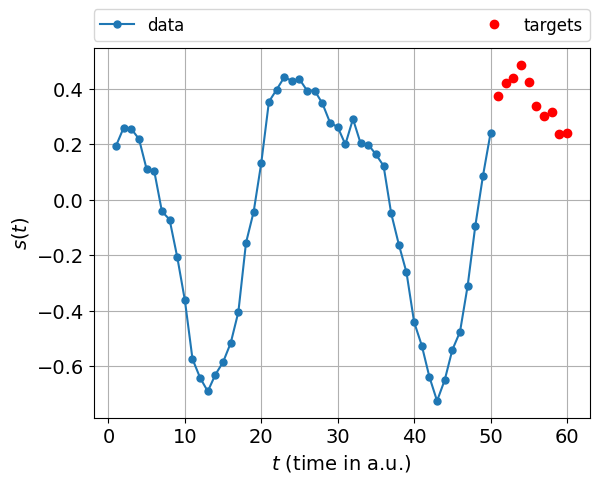

In [6]:
j=np.random.randint(X_test.shape[0])
print('j=',j)
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + 11)),Y_test[j],'ro',label='targets')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
# Show the plot
plt.show()

# **Predicting next time step of the time series**

# Baseline (naive prediction): predicting the next time step



In [10]:
#BASELINE1
#we predict the last value from each series
y_pred = X_test[:, -1]
print("y_pred baseline shape=",y_pred.shape)
print('MSE: ')
np.mean(tf.keras.metrics.mse(Y_test,y_pred))

y_pred baseline shape= (100, 1)
MSE: 


0.24156159

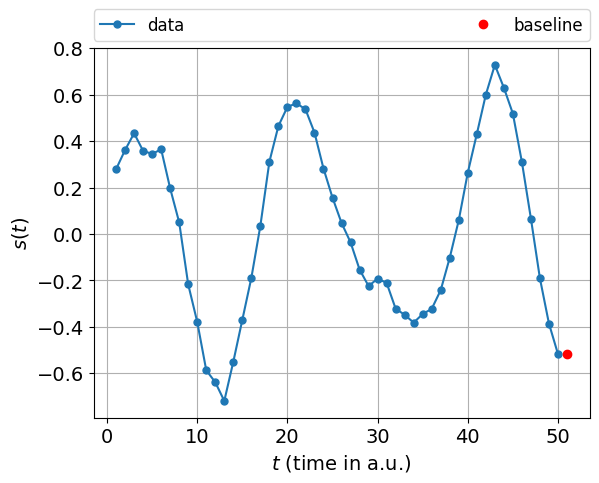

In [11]:
j=np.random.randint(X_test.shape[0])
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + 2)),y_pred[j],'ro',label='baseline')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
# Show the plot
plt.show()

# **Single Neuron**

## Dense Neural Network (DNN)

In [12]:
model1 = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=(50, 1)),
tf.keras.layers.Dense(1)
])

model1.summary()
model1.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history1=model1.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51 (204.00 B)

 Trainable params: 51 (204.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2130 - mae: 0.3573 - val_loss: 0.1110 - val_mae: 0.2753
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1207 - mae: 0.2849 - val_loss: 0.0759 - val_mae: 0.2268
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0881 - mae: 0.2490 - val_loss: 0.0640 - val_mae: 0.2097
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0716 - mae: 0.2220 - val_loss: 0.0562 - val_mae: 0.1966
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0608 - mae: 0.2021 - val_loss: 0.0488 - val_mae: 0.1839
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0529 - mae: 0.1870 - val_loss: 0.0428 - val_mae: 0.1726
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0497 - mae: 0.1816 - val_loss: 0.0378 - val_mae: 0.1627
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0403 - mae: 0.1621 - val_loss: 0.0335 - val_mae: 0.1533
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0348 - mae:

In [14]:
ypred=model1.predict(X_test)
np.mean(tf.keras.metrics.mse(Y_test, ypred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


0.19327135

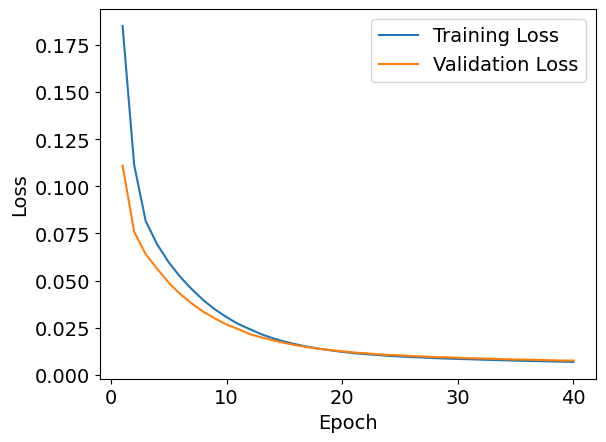

In [15]:
plot_history(history1)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(1, 1)
MSE= 0.0009753466


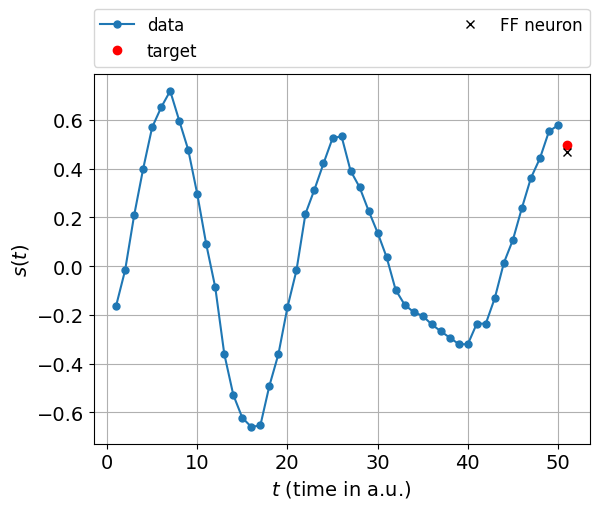

In [18]:
plot_time_series(X_test,Y_test,model=model1,model_name='FF neuron')

## Recurrent Neural Network (RNN)


Parameters per layer:
+ $W_x=n_{inputs} \times n_{neurons}$
+ $W_y=n_{neurons} \times n_{neurons}$
+ $b= n_{neurons}$

### Simple RNN

In [19]:
'''
By deafault, it will only return the last output, hyperbolic tangent activation
initial sate is set to 0.

We do not need to specify the length of the
input sequences (unlike with DNN), since a RNNs can
process any number of time steps (this is why we set the first input dimension to None)
'''
model2 = tf.keras.models.Sequential([
#tf.keras.layers.Flatten(input_shape=(50, 1)),        # Compare this line
tf.keras.layers.SimpleRNN(1, input_shape=(None, 1))]) # with this
model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
model2.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history2=model2.fit(X_train, Y_train[:,0],
                    epochs=40,
                    validation_data=(X_val, Y_val[:,0]))

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.3178 - mae: 0.4875 - val_loss: 0.2772 - val_mae: 0.4546
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2871 - mae: 0.4640 - val_loss: 0.2383 - val_mae: 0.4220
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2505 - mae: 0.4347 - val_loss: 0.2176 - val_mae: 0.4005
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2240 - mae: 0.4106 - val_loss: 0.2125 - val_mae: 0.3998
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2182 - mae: 0.4044 - val_loss: 0.2056 - val_mae: 0.3908
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2105 - mae: 0.3983 - val_loss: 0.2029 - val_mae: 0.3836
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2005 - mae: 0.3866 - val_loss: 0.1983 - val_mae: 0.3790
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2085 - mae: 0.3955 - val_loss: 0.1892 - val_mae: 0.3747
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1944 - mae:

In [21]:
ypred=model2.predict(X_test)
np.mean(tf.keras.metrics.mse(Y_test[:,0], ypred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


0.18182416

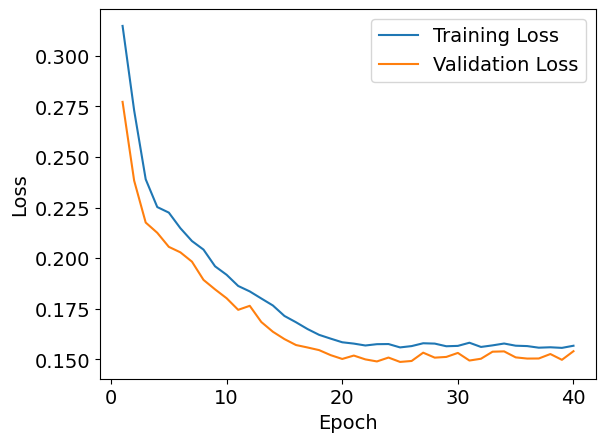

In [22]:
plot_history(history2)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
(1, 1)
MSE= 0.047359776


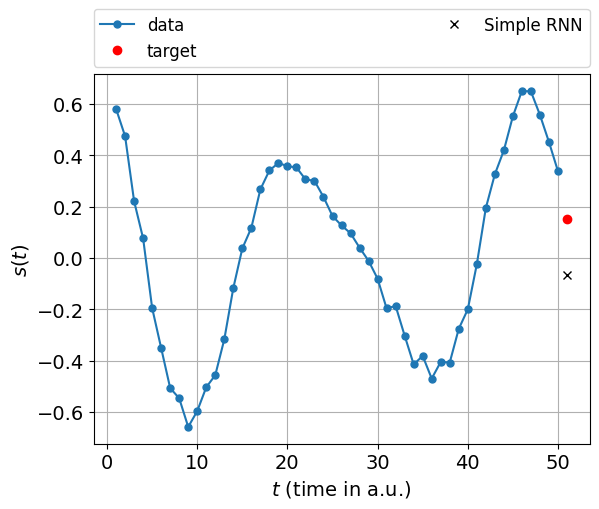

In [23]:
plot_time_series(X_test,Y_test,model=model2,model_name='Simple RNN')

### Custom Simple RNN code

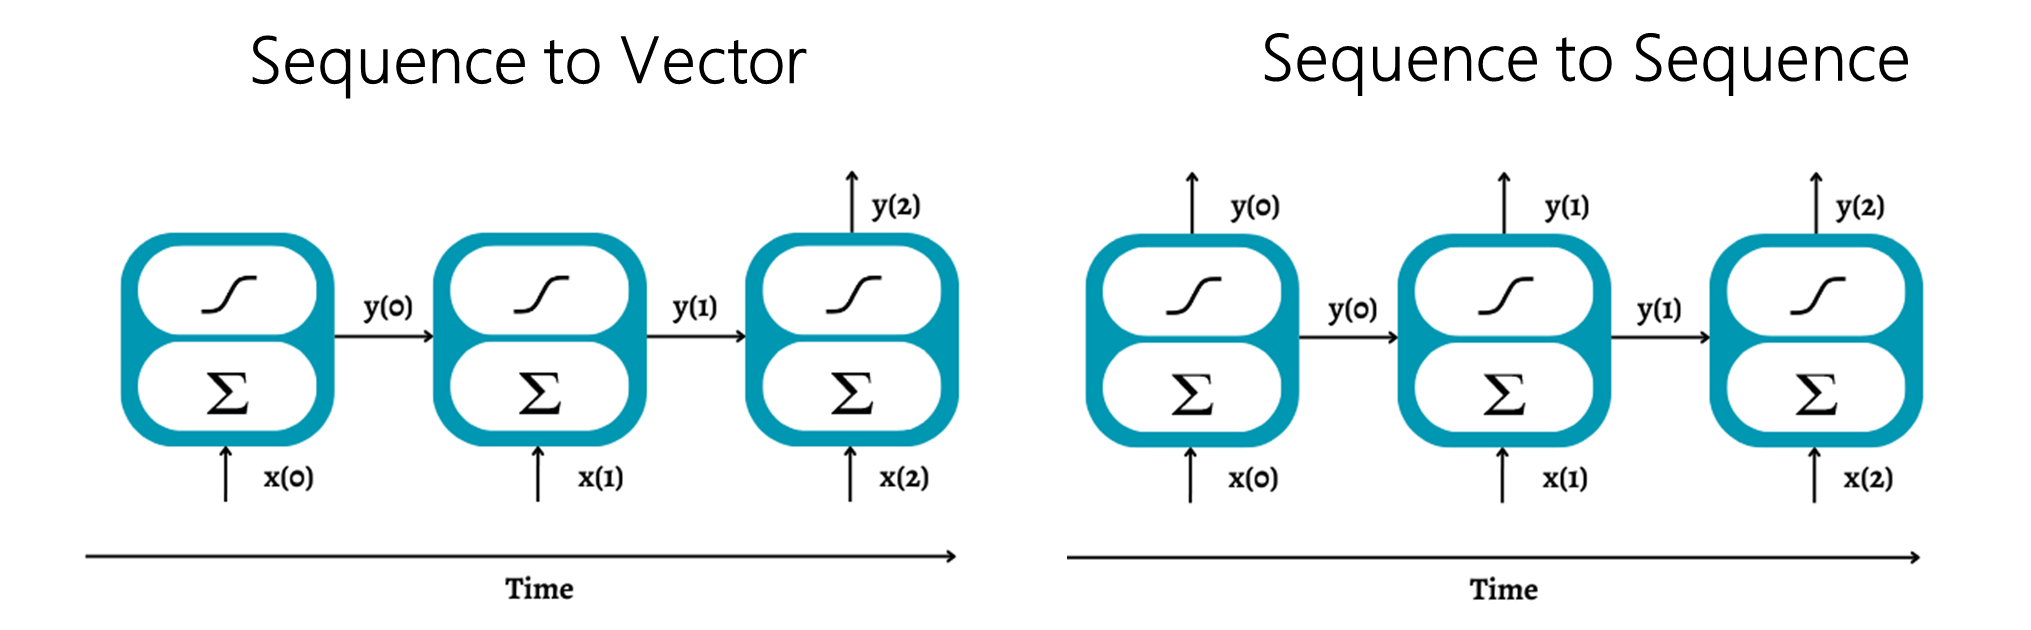

In [24]:
# Will take the weights from the SimpleRNN model
model2.weights

[<KerasVariable shape=(1, 1), dtype=float32, path=sequential_1/simple_rnn/simple_rnn_cell/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=sequential_1/simple_rnn/simple_rnn_cell/recurrent_kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=sequential_1/simple_rnn/simple_rnn_cell/bias>]

successive output length= 50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Custom SimpleRNN prediction shape= (50,)
Keras SimpleRNN shape= (1,)


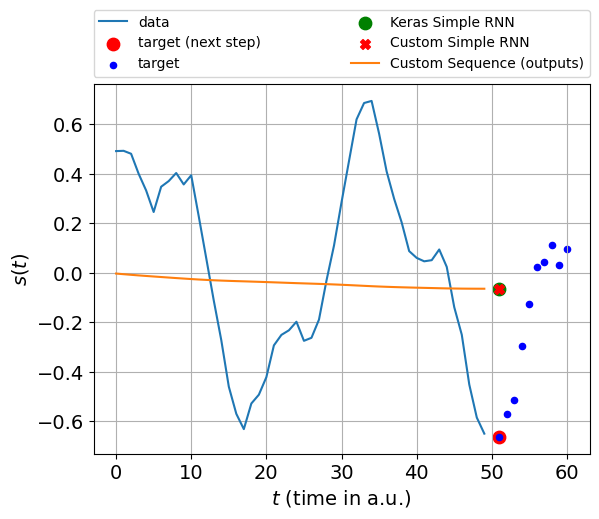

In [25]:
import numpy as np
# Take a random series from X_test
j=np.random.randint(X_test.shape[0])
inputs =X_test[j]

# Input_features and output_feauteres of the RNN cell
input_features = 1
output_features = 1

# Initial state of the RNN cell
state_t = np.zeros((output_features,))

# Weights and bias
model=model2
W=model.weights[0].numpy() # Regular kernel
U=model.weights[1].numpy() # Recurrent Kernel
b=model.weights[2].numpy() # bias

# List to add the successive outputs
successive_outputs = []

# Recurrent loop: for every time step (input_t) y produces the output_t
# that is appended into a list
# The state is updated in each iteration
for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  successive_outputs.append(output_t)
  state_t = output_t
  #print("input t=",input_t)
  #print("output t=",output_t)

# Get the final output sequence
print("successive output length=",len(successive_outputs))
final_output_sequence = np.concatenate(successive_outputs, axis=0)

# Predictions
pred_naive=final_output_sequence
pred_keras_SimpleRNN=model.predict(X_test)[j]
print("Custom SimpleRNN prediction shape=",pred_naive.shape)
print("Keras SimpleRNN shape=",pred_keras_SimpleRNN.shape)

# Plot
plt.plot(inputs,label='data')
plt.scatter(51,Y_test[j,0],label='target (next step)',color='red',marker='o',s=80)
plt.scatter(np.arange(51,61),Y_test[j,:],label='target',color='blue',marker='o',s=20)
plt.scatter(51,pred_keras_SimpleRNN,label='Keras Simple RNN',color='green',marker='o',s=80)
plt.scatter(51,pred_naive[-1],label='Custom Simple RNN',color='red',marker='X',s=50)
plt.plot(pred_naive,label='Custom Sequence (outputs)')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=10)
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.show()

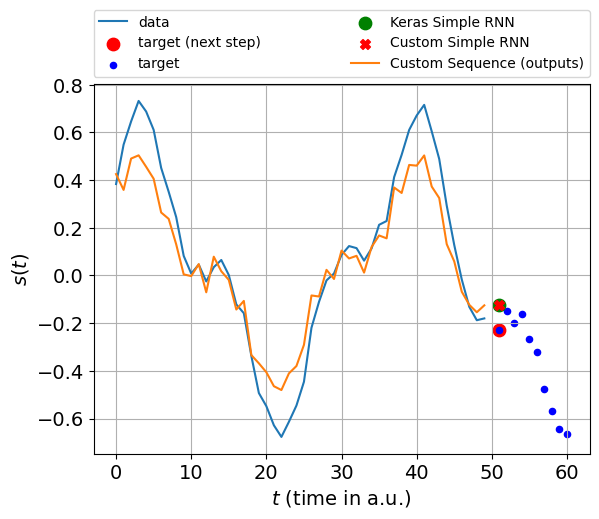

### LSTM

In [26]:
'''
By deafault, it will only return the last output, hyperbolic tangent activation
initial sate is set to 0

We do not need to specify the length of the
input sequences (unlike in the previous model), since a recurrent neural network can
process any number of time steps (this is why we set the first input dimension to None)
'''
model3 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(1, input_shape=(None, 1))])

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
model3.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history3=model3.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1440 - mae: 0.3169 - val_loss: 0.1242 - val_mae: 0.2940
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1407 - mae: 0.3160 - val_loss: 0.1160 - val_mae: 0.2859
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1197 - mae: 0.2921 - val_loss: 0.1100 - val_mae: 0.2803
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1152 - mae: 0.2864 - val_loss: 0.1053 - val_mae: 0.2756
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1173 - mae: 0.2916 - val_loss: 0.1019 - val_mae: 0.2716
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1065 - mae: 0.2768 - val_loss: 0.0992 - val_mae: 0.2680
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1059 - mae: 0.2756 - val_loss: 0.0972 - val_mae: 0.2650
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1066 - mae: 0.2789 - val_loss: 0.0954 - val_mae: 0.2623
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0958 - 

In [28]:
ypred=model3.predict(X_test)
np.mean(tf.keras.metrics.mse(Y_test, ypred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


0.20453274

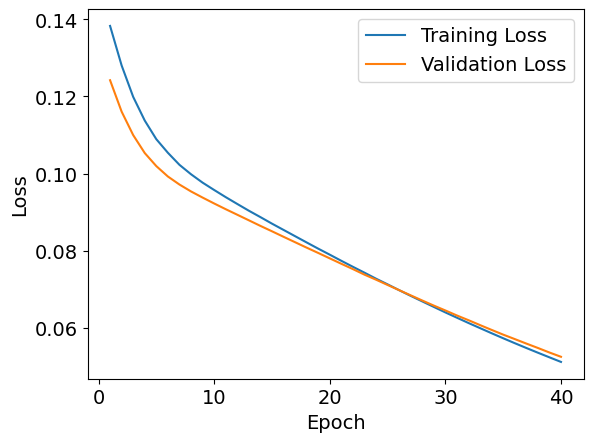

In [29]:
plot_history(history3)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
(1, 1)
MSE= 0.12559503


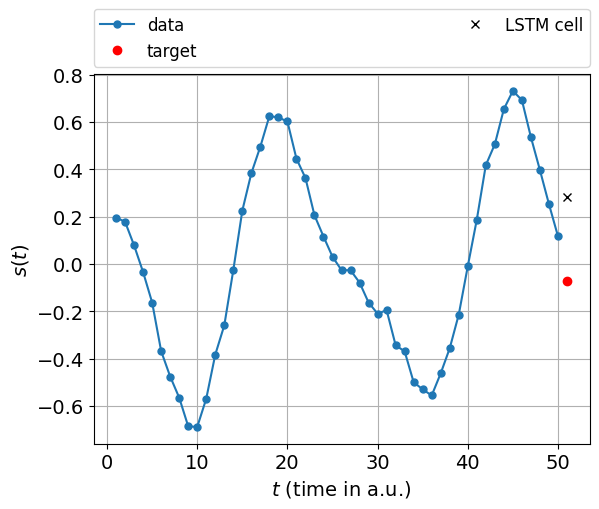

In [30]:
plot_time_series(X_test,Y_test,model=model3,model_name='LSTM cell')

### GRU

In [31]:
model4 = tf.keras.models.Sequential([
tf.keras.layers.GRU(1, input_shape=(None, 1))])

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
model4.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history4=model4.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2368 - mae: 0.4265 - val_loss: 0.2172 - val_mae: 0.4095
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2189 - mae: 0.4130 - val_loss: 0.2085 - val_mae: 0.4011
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2046 - mae: 0.3993 - val_loss: 0.2004 - val_mae: 0.3932
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2049 - mae: 0.3986 - val_loss: 0.1934 - val_mae: 0.3860
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1965 - mae: 0.3911 - val_loss: 0.1866 - val_mae: 0.3790
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1878 - mae: 0.3837 - val_loss: 0.1802 - val_mae: 0.3724
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1811 - mae: 0.3768 - val_loss: 0.1744 - val_mae: 0.3664
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1796 - mae: 0.3765 - val_loss: 0.1693 - val_mae: 0.3609
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1750 - ma

In [33]:
ypred=model4.predict(X_test)
np.mean(tf.keras.metrics.mse(Y_test, ypred))

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


0.17363887

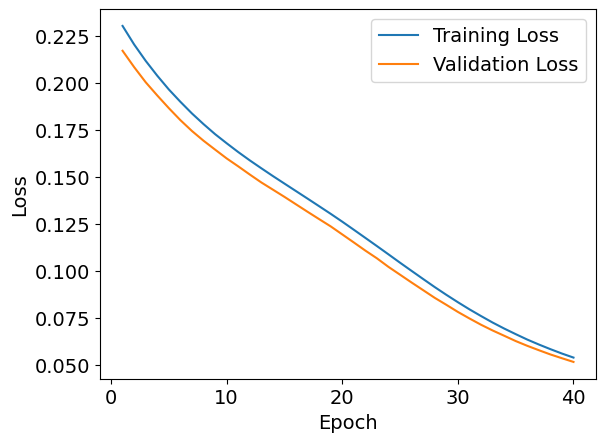

In [34]:
plot_history(history4)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(1, 1)
MSE= 0.1454718


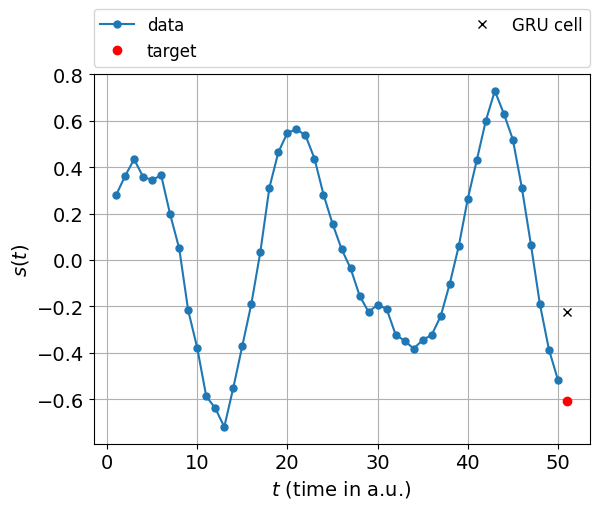

In [35]:
plot_time_series(X_test,Y_test,model=model4,model_name='GRU cell')

# **Deep Neural Networks**

### Dense Neural Network (DNN)

In [36]:
model5 = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=[50, 1]),
tf.keras.layers.Dense(20),
tf.keras.layers.Dense(20),
tf.keras.layers.Dense(1)
])

model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,461 (5.71 KB)

 Trainable params: 1,461 (5.71 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model5.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history5=model5.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1493 - mae: 0.3078 - val_loss: 0.0362 - val_mae: 0.1566
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332 - mae: 0.1450 - val_loss: 0.0176 - val_mae: 0.1092
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - mae: 0.0996 - val_loss: 0.0139 - val_mae: 0.0941
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - mae: 0.0871 - val_loss: 0.0123 - val_mae: 0.0891
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - mae: 0.0846 - val_loss: 0.0110 - val_mae: 0.0841
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - mae: 0.0791 - val_loss: 0.0092 - val_mae: 0.0751
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - mae: 0.0785 - val_loss: 0.0082 - val_mae: 0.0713
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - mae: 0.0747 - val_loss: 0.0077 - val_mae: 0.0680
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - mae:

In [38]:
ypred=model5.predict(X_test)
np.mean(tf.keras.metrics.mse(Y_test, ypred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


0.20038557

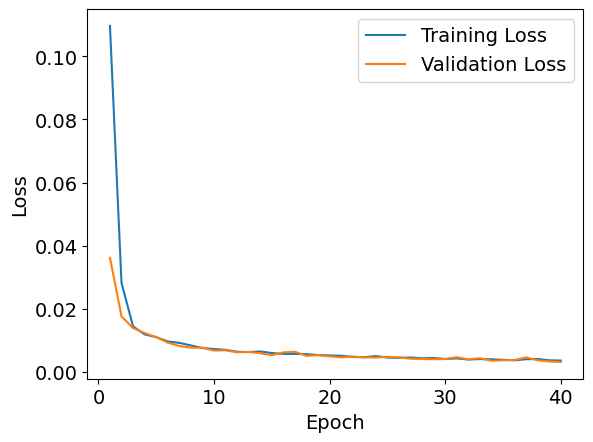

In [39]:
plot_history(history5)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
(1, 1)
MSE= 0.0010084615


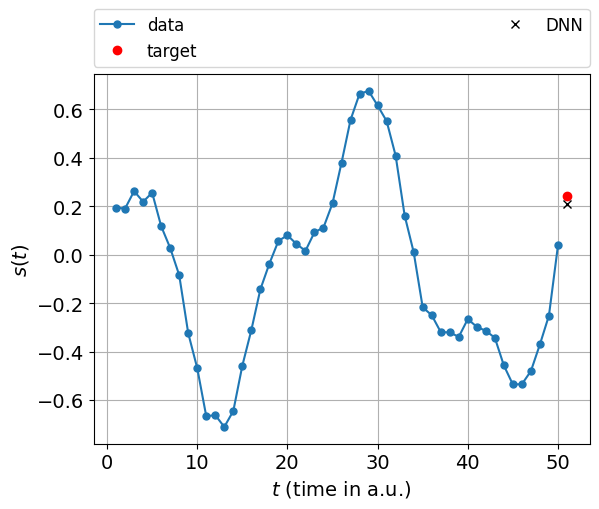

In [40]:
plot_time_series(X_test,Y_test,model=model5,model_name='DNN')

## Recurrent Neural Networks (RNN)

###Simple RNN

Parameters per layer:
+ $W_x=n_{inputs} \times n_{neurons}$
+ $W_y=n_{neurons} \times n_{neurons}$
+ $b= n_{neurons}$

In [41]:
'''
Set return_sequences=True for all recurrent layers except the last one
It returns the entire sequence of outputs for each sample (one vector per timestep per sample).
The shape of this output is (batch_size, timesteps, units='neurons')
'''
model6 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.SimpleRNN(20, return_sequences=True),
tf.keras.layers.SimpleRNN(1)
])

model6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, None, 20)            │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, None, 20)            │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 1)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
for layer in model6.layers:
  print("\n",layer.name)
  print("Layer input shape=",layer.input.shape)
  print("Layer output shape=",layer.output.shape)


 simple_rnn_1
Layer input shape= (None, None, 1)
Layer output shape= (None, None, 20)

 simple_rnn_2
Layer input shape= (None, None, 20)
Layer output shape= (None, None, 20)

 simple_rnn_3
Layer input shape= (None, None, 20)
Layer output shape= (None, 1)


In [43]:
model6.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history6=model6.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.3363 - mae: 0.4923 - val_loss: 0.1144 - val_mae: 0.2690
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1008 - mae: 0.2568 - val_loss: 0.0465 - val_mae: 0.1766
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0480 - mae: 0.1839 - val_loss: 0.0389 - val_mae: 0.1590
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0363 - mae: 0.1593 - val_loss: 0.0271 - val_mae: 0.1348
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0281 - mae: 0.1357 - val_loss: 0.0246 - val_mae: 0.1288
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0246 - mae: 0.1293 - val_loss: 0.0237 - val_mae: 0.1250
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0228 - mae: 0.1236 - val_loss: 0.0210 - val_mae: 0.1198
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0201 - mae: 0.1169 - val_loss: 0.0197 - val_mae: 0.1140
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.01

In [44]:
ypred=model6.predict(X_test)
np.mean(tf.keras.metrics.mse(Y_test, ypred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


0.18999363

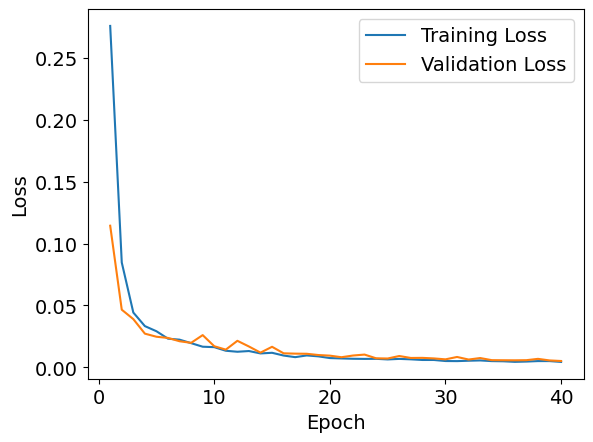

In [45]:
plot_history(history6)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
(1, 1)
MSE= 5.200926e-05


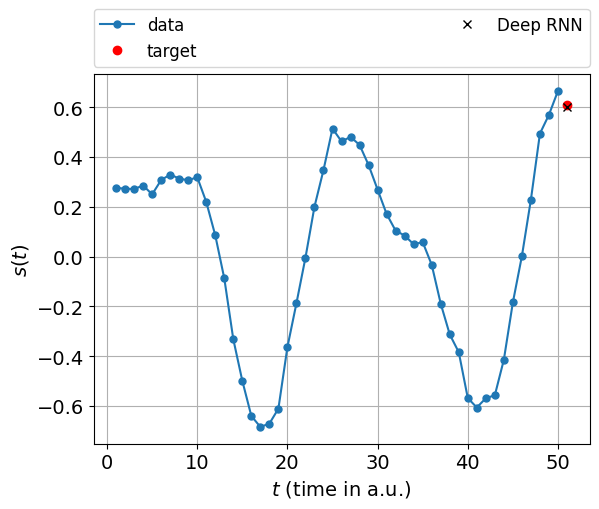

In [46]:
plot_time_series(X_test,Y_test,model=model6,model_name='Deep RNN')

In [47]:
model7 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.SimpleRNN(20),
tf.keras.layers.Dense(1)
])

model7.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, None, 20)            │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model7.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history7=model7.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.1086 - mae: 0.2514 - val_loss: 0.0204 - val_mae: 0.1155
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0160 - mae: 0.1031 - val_loss: 0.0125 - val_mae: 0.0892
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0123 - mae: 0.0867 - val_loss: 0.0088 - val_mae: 0.0771
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0076 - mae: 0.0681 - val_loss: 0.0079 - val_mae: 0.0718
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061 - mae: 0.0622 - val_loss: 0.0065 - val_mae: 0.0657
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0051 - mae: 0.0575 - val_loss: 0.0058 - val_mae: 0.0607
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0050 - mae: 0.0567 - val_loss: 0.0051 - val_mae: 0.0564
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0044 - mae: 0.0541 - val_loss: 0.0048 - val_mae: 0.0553
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.004

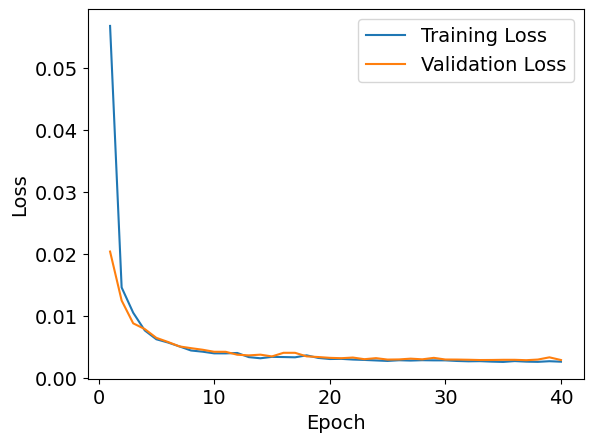

In [49]:
plot_history(history7)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
(1, 1)
MSE= 0.0011331538


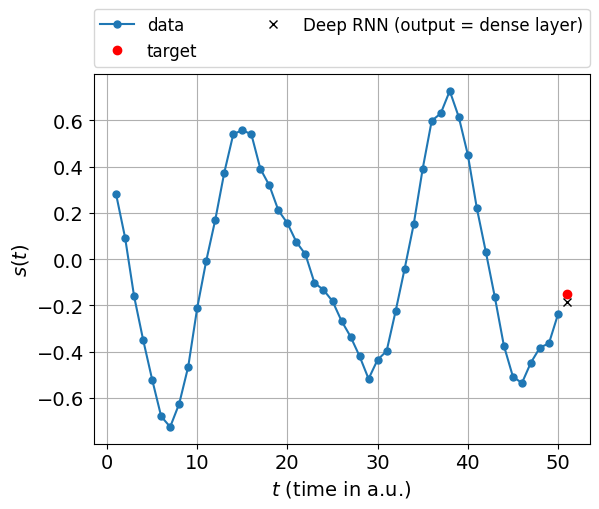

In [50]:
plot_time_series(X_test,Y_test,model=model7,model_name='Deep RNN (output = dense layer)')

### LSTM

In [51]:
model8 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.LSTM(20),
tf.keras.layers.Dense(1)
])

model8.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, None, 20)            │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 20)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model8.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history8=model8.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1483 - mae: 0.3382 - val_loss: 0.1024 - val_mae: 0.2746
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0884 - mae: 0.2516 - val_loss: 0.0528 - val_mae: 0.1905
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0541 - mae: 0.1859 - val_loss: 0.0439 - val_mae: 0.1732
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0440 - mae: 0.1692 - val_loss: 0.0405 - val_mae: 0.1671
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0398 - mae: 0.1618 - val_loss: 0.0377 - val_mae: 0.1619
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0351 - mae: 0.1512 - val_loss: 0.0352 - val_mae: 0.1560
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0375 - mae: 0.1574 - val_loss: 0.0354 - val_mae: 0.1549
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0343 - mae: 0.1494 - val_loss: 0.0309 - val_mae: 0.1461
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0311 - mae

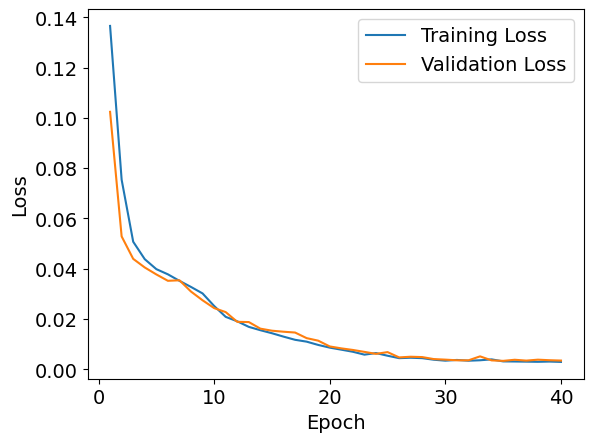

In [53]:
plot_history(history8)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
(1, 1)
MSE= 0.003614678


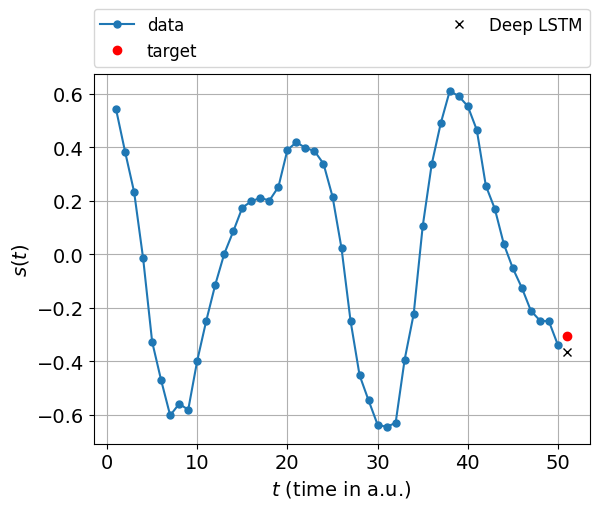

In [54]:
plot_time_series(X_test,Y_test,model=model8,model_name='Deep LSTM')



### GRU

In [55]:
model9 = tf.keras.models.Sequential([
tf.keras.layers.GRU(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.GRU(20),
tf.keras.layers.Dense(1)
])

model9.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, None, 20)            │           1,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 20)                  │           2,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,921 (15.32 KB)

 Trainable params: 3,921 (15.32 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model9.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history9=model9.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1710 - mae: 0.3647 - val_loss: 0.1050 - val_mae: 0.2767
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0936 - mae: 0.2616 - val_loss: 0.0522 - val_mae: 0.1864
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0448 - mae: 0.1726 - val_loss: 0.0280 - val_mae: 0.1411
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0247 - mae: 0.1280 - val_loss: 0.0235 - val_mae: 0.1293
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0227 - mae: 0.1241 - val_loss: 0.0218 - val_mae: 0.1230
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0190 - mae: 0.1121 - val_loss: 0.0191 - val_mae: 0.1166
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0177 - mae: 0.1067 - val_loss: 0.0177 - val_mae: 0.1134
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147 - mae: 0.0993 - val_loss: 0.0149 - val_mae: 0.1025
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0140

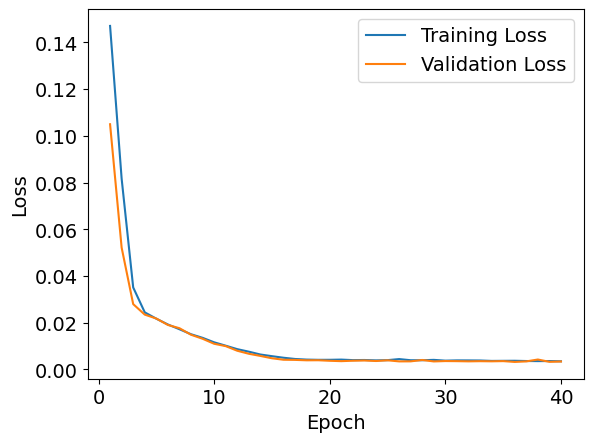

In [57]:
plot_history(history9)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
(1, 1)
MSE= 0.0029326663


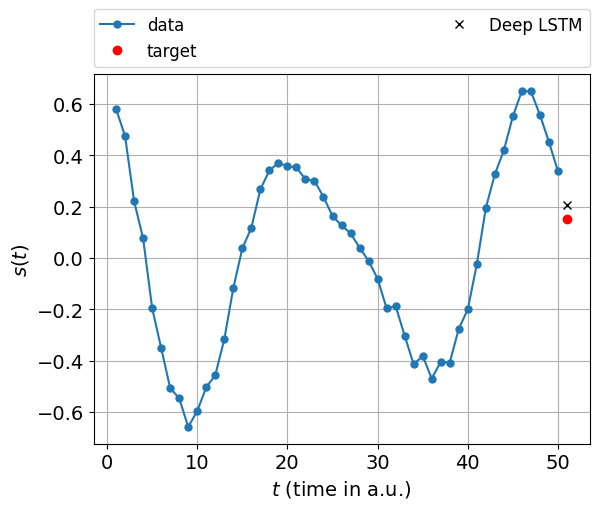

In [58]:
plot_time_series(X_test,Y_test,model=model9,model_name='Deep LSTM')

# **Forecasting several time steps from a pre-trained RNN**

Options:
1.   **Iterative method**: Forecast the next step, add it to the timeseriries, and repeat
2.   **Sequence to vector**: predict the last timesteps (targets).
3.   **Sequence to sequence**: give all steps at once.

## Forecasting the next step iteratively


In [59]:
model= model8 #Choose one of the already trained models

In [60]:
# Prediction
j = np.random.randint(0, len(Y_test))

sequence=X_test[j].reshape(1,X_train.shape[1], 1)
print("Sequence shape=",sequence.shape)

for i in range (0,n_target):
  pred=model.predict(sequence[:,i:,:],verbose=0) #predict next timestep with previous steps
  sequence=np.concatenate((sequence, pred.reshape(1, 1, 1)), axis=1) #add it to the sequence
  print("Sequence shape=",sequence.shape)
prediction=np.squeeze(sequence[0,n_steps:,:])

print("\nPrediction=\n",prediction)

Sequence shape= (1, 50, 1)
Sequence shape= (1, 51, 1)
Sequence shape= (1, 52, 1)
Sequence shape= (1, 53, 1)
Sequence shape= (1, 54, 1)
Sequence shape= (1, 55, 1)
Sequence shape= (1, 56, 1)
Sequence shape= (1, 57, 1)
Sequence shape= (1, 58, 1)
Sequence shape= (1, 59, 1)
Sequence shape= (1, 60, 1)

Prediction=
 [0.17876008 0.30380467 0.4300444  0.5334336  0.5982028  0.6140476
 0.57523996 0.4790256  0.32587075 0.12121755]


MSE= 0.040563125


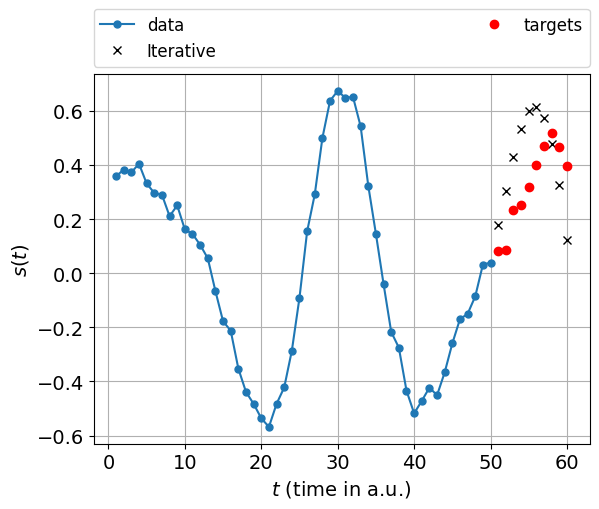

In [61]:
print("MSE=",tf.keras.metrics.mse(prediction,Y_test[j]).numpy())

# Plot
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + 11)),prediction,'x',color='black',label='Iterative')
plt.plot(list(range(n_steps + 1,n_steps + 11)),Y_test[j],'ro',label='targets')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
plt.show()

## LSTM Sequence-to-Vector

In [62]:
model10 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.LSTM(20),
tf.keras.layers.Dense(10) # Compare to model 8
])
model10.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, None, 20)            │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 20)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,250 (20.51 KB)

 Trainable params: 5,250 (20.51 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model10.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history10=model10.fit(X_train, Y_train, epochs=40, validation_data=(X_val, Y_val))

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1436 - mae: 0.3293 - val_loss: 0.1231 - val_mae: 0.3034
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1193 - mae: 0.2969 - val_loss: 0.0825 - val_mae: 0.2368
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0779 - mae: 0.2275 - val_loss: 0.0651 - val_mae: 0.2063
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0665 - mae: 0.2087 - val_loss: 0.0578 - val_mae: 0.1932
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0568 - mae: 0.1916 - val_loss: 0.0517 - val_mae: 0.1828
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0487 - mae: 0.1777 - val_loss: 0.0480 - val_mae: 0.1756
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0441 - mae: 0.1705 - val_loss: 0.0438 - val_mae: 0.1684
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0407 - mae: 0.1636 - val_loss: 0.0414 - val_mae: 0.1649
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0388

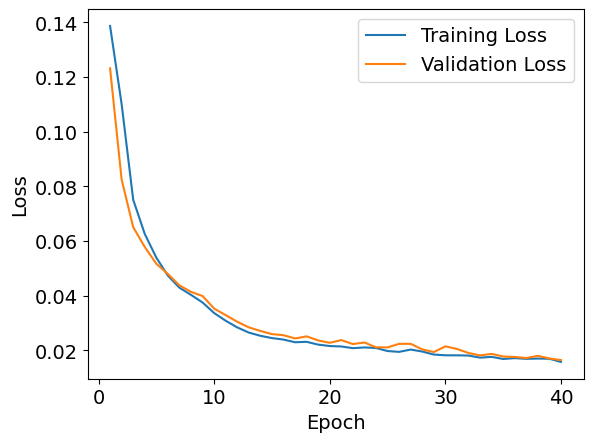

In [65]:
plot_history(history10)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
(1, 10)
MSE= [0.0143325]


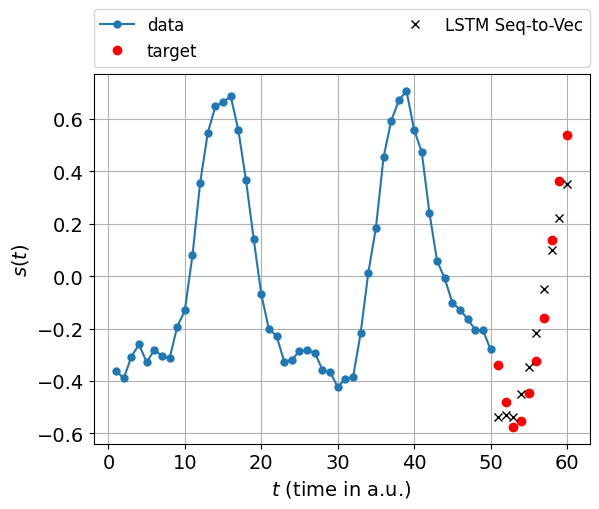

In [66]:
plot_time_series(X_test,Y_test,model=model10,model_name='LSTM Seq-to-Vec')

##LSTM Sequence-to-Sequence

### Generating data

In [67]:
# Every target will contain n_steps vectors of dimension 10, each one shifted by 10 steps.
n_steps = 50
n_target=10

Y = np.empty((N_series, n_steps, n_target)) # each target is a sequence of 10D vectors

for step_ahead in range(1, n_target + 1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]

Y_train_s2s = Y[:N_train]
Y_val_s2s = Y[N_train:N_train+N_val]
Y_test_s2s = Y[N_train+N_val:]

x_train shape= (700, 50, 1)
y_train shape= (700, 50, 10)


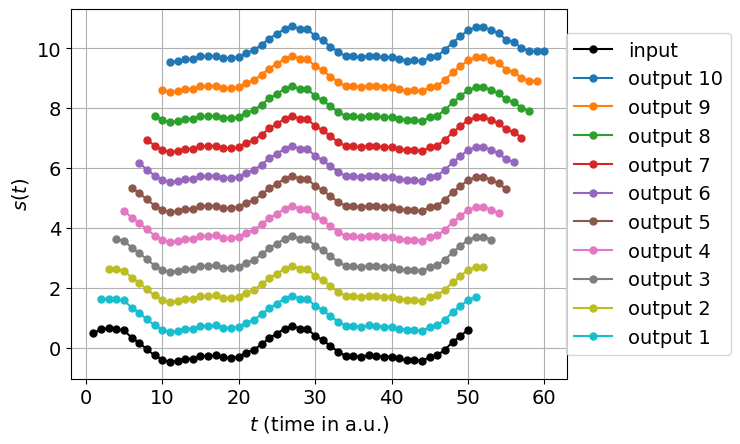

In [68]:
print("x_train shape=",X_train.shape)
print("y_train shape=",Y_train_s2s.shape)

j=np.random.randint(X_test.shape[0])

# Plot
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],color='black',label='input',markersize=5,marker='o')
for step_ahead in range(n_target ,0,-1):
  plt.plot(list(range(1+step_ahead, step_ahead+n_steps+1)),Y_test_s2s[j,:,step_ahead-1]+step_ahead,markersize=5,marker='o',label="output "+str(step_ahead))
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
plt.grid(True)
plt.show()

### The LSTM network


In [69]:
model11 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.LSTM(20, return_sequences=True),
tf.keras.layers.Dense(10)
])

model11.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, None, 20)            │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, None, 20)            │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, None, 10)            │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,250 (20.51 KB)

 Trainable params: 5,250 (20.51 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model11.compile(loss="mse", optimizer=optimizer, metrics=['mae'])

In [71]:
history11=model11.fit(X_train, Y_train_s2s, epochs=40, validation_data=(X_val, Y_val_s2s))

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1143 - mae: 0.2835 - val_loss: 0.0732 - val_mae: 0.2185
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0633 - mae: 0.2015 - val_loss: 0.0609 - val_mae: 0.1976
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0533 - mae: 0.1827 - val_loss: 0.0500 - val_mae: 0.1737
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0450 - mae: 0.1627 - val_loss: 0.0427 - val_mae: 0.1584
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0392 - mae: 0.1507 - val_loss: 0.0379 - val_mae: 0.1474
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0354 - mae: 0.1411 - val_loss: 0.0336 - val_mae: 0.1349
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0334 - mae: 0.1352 - val_loss: 0.0337 - val_mae: 0.1352
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0318 - mae: 0.1322 - val_loss: 0.0307 - val_mae: 0.1275
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0296

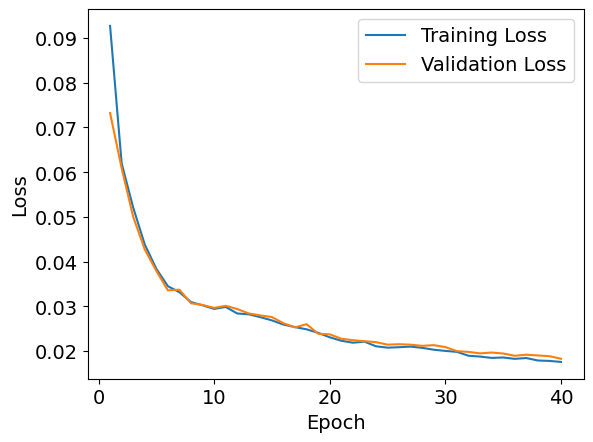

In [72]:
plot_history(history11)

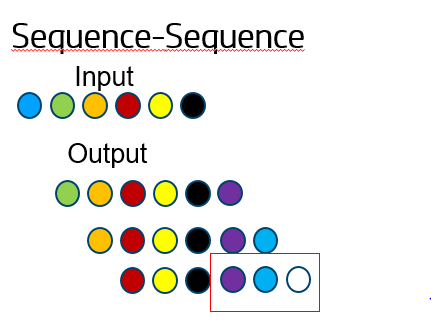

Y_test shape= (100, 50, 10)
Prediction shape= (1, 50, 10)

MSE= 0.015990281139713285


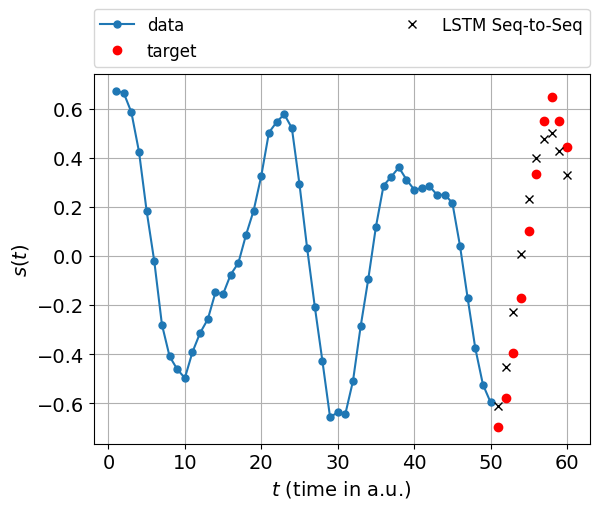

In [73]:
# Y_test_s2s = (batch_size,time_steps,target_points)
# Note that Y_test_s2s[j,:,i] is the data (X_test) shifted i+1 steps ahead
# Y_test_s2s[j,-1,:] = Y_test_s2s[j,-1] = Y_test_s2s[j][-1]
# are the last target_points values of all the shifted functions

n_target=10
j=np.random.randint(X_test.shape[0])
pred=model11.predict(X_test[j].reshape(1, 50, 1),verbose=0)
print("Y_test shape=",Y_test_s2s.shape)
print("Prediction shape=",pred.shape)

print("\nMSE=",tf.keras.metrics.mse(pred[0][-1],Y_test_s2s[j][-1]).numpy())

# Plot
plt.rcParams.update({'font.size': 14})
plt.plot(np.arange(1, n_steps + 1),X_test[j],label='data',marker='o',markersize=5)
plt.plot(np.arange(n_steps + 1,n_steps + n_target+1),Y_test_s2s[j][-1],'ro',label='target')
plt.plot(np.arange(n_steps + 1,n_steps + n_target+1),pred[0][-1],'x',color='black',label='LSTM Seq-to-Seq')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
plt.show()
